## Load Packages

In [62]:
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.preprocessing import PowerTransformer, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,  TransformedTargetRegressor

from env import *
from plotting.unique import *
from plotting.missing import *
from plotting.correlation import *
from processing.data import Data

pd.pandas.set_option('display.max_columns', None)

## Import Data

In [2]:

train = Data.from_csv(filepath=DIR_DATA_TRAIN, index_col=COL_ID)
test  = Data.from_csv(filepath=DIR_DATA_TEST, index_col=COL_ID)
print(train)
repr(train)

Table metadata updated
Table metadata updated
A dataframe with 1460 rows and 80 columns


'Data(df)'

In [3]:
# Create more human-readable columns
for regex, repl in REGEX_REPL_COLUMN:
    train.columns = train.columns.map(lambda x: re.sub(string=x, pattern=regex, repl=repl))
    test.columns = test.columns.map(lambda x: re.sub(string=x, pattern=regex, repl=repl))

train.columns = train.columns.map(str.lower)
test.columns  = test.columns.map(str.lower)

train.col_target = COL_TARGET
test.col_target = COL_TARGET

print(f'Columns of training data: {train.columns.tolist()}')

Columns of training data: ['ms_sub_class', 'ms_zoning', 'lot_frontage', 'lot_area', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'building_type', 'house_style', 'overall_quality', 'overall_condition', 'year_built', 'year_remod_add', 'roof_style', 'roof_material', 'exterior1st', 'exterior2nd', 'masonry_veneer_type', 'masonry_veneer_area', 'external_quality', 'external_condition', 'foundation', 'basement_quality', 'basement_condition', 'basement_exposure', 'basement_finished_type_1', 'basement_finished_sq_ft_1', 'basement_finished_type_2', 'basement_finished_sq_ft_2', 'basement_unf_sq_ft', 'total_basement_sq_ft', 'heating', 'heating_quality_condition', 'central_air', 'electrical', '1st_floor_sq_ft', '2nd_floor_sq_ft', 'low_quality_finished_sq_ft', 'ground_liv_area', 'basement_full_bath', 'basement_half_bath', 'full_bath', 'half_bath', 'bedroom_above_ground', 'kitchen_above_ground', 'kitchen_quality'

## Variable Types

In [4]:
train.print_column_types()

There are 43 categorical fields:
['ms_zoning', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'building_type', 'house_style', 'roof_style', 'roof_material', 'exterior1st', 'exterior2nd', 'masonry_veneer_type', 'external_quality', 'external_condition', 'foundation', 'basement_quality', 'basement_condition', 'basement_exposure', 'basement_finished_type_1', 'basement_finished_type_2', 'heating', 'heating_quality_condition', 'central_air', 'electrical', 'kitchen_quality', 'functional', 'fireplace_qu', 'garage_type', 'garage_finish', 'garage_quality', 'garage_condition', 'paved_drive', 'pool_quality_condition', 'fence', 'misc_feature', 'sale_type', 'sale_condition']
There are 37 numerical fields:
['ms_sub_class', 'lot_frontage', 'lot_area', 'overall_quality', 'overall_condition', 'year_built', 'year_remod_add', 'masonry_veneer_area', 'basement_finished_sq_ft_1', 'basement_finished_sq_ft_2', 'basement_unf

In [5]:
train.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ms_sub_class                1460 non-null   int64  
 1   ms_zoning                   1460 non-null   object 
 2   lot_frontage                1201 non-null   float64
 3   lot_area                    1460 non-null   int64  
 4   street                      1460 non-null   object 
 5   alley                       91 non-null     object 
 6   lot_shape                   1460 non-null   object 
 7   land_contour                1460 non-null   object 
 8   utilities                   1460 non-null   object 
 9   lot_config                  1460 non-null   object 
 10  land_slope                  1460 non-null   object 
 11  neighborhood                1460 non-null   object 
 12  condition_1                 1460 non-null   object 
 13  condition_2                 1460 

## Remove Uninformative Features

In [6]:
train.drop_columns_regex(regex='^misc')


Removed columns:
['misc_feature', 'misc_value']
Table metadata updated


## Unique Values

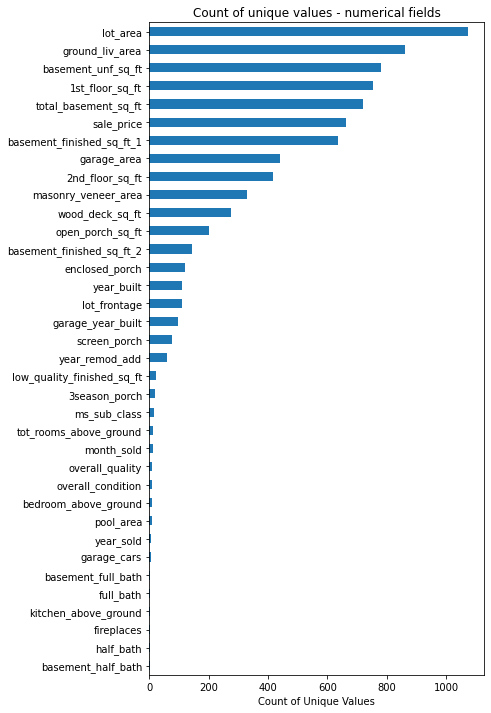

In [7]:
plot_count_unique(train.df, 
                  dtype_include=['float64', 'int64'],
                  title='Count of unique values - numerical fields')

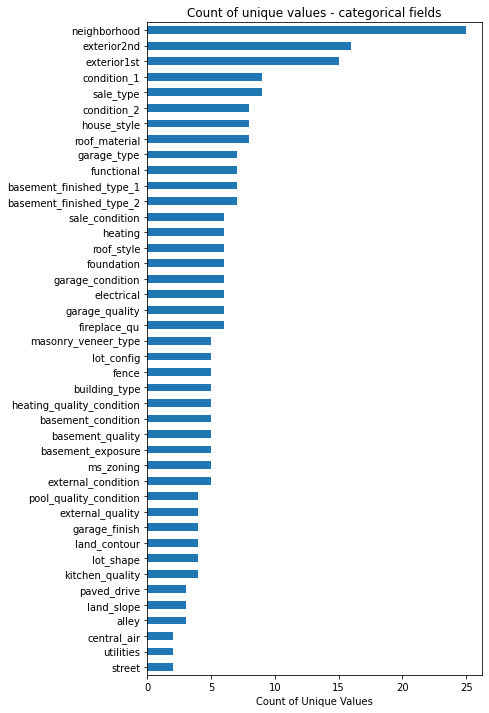

In [8]:
plot_count_unique(train.df, 
                  dtype_include=['O'],
                  title='Count of unique values - categorical fields')

In [9]:
train.remove_constant_columns()

Table metadata updated
Found 0 constant column(s).
Removed columns:
[]


### Aggregate low count categorical features to 'other' category

In [10]:
cat_count_unique = train.count_unique(dtypes='object')

CATEGORICAL_COL_COUNT_THRESHOLD = 10
CATEGORICAL_GROUPING_THRESHOLD = 0.01

for col in cat_count_unique.index[cat_count_unique > CATEGORICAL_COL_COUNT_THRESHOLD]:

    # Apply grouping of categories to training set
    cat_group_mapping = train.group_low_count_categories(col=col, fill_value='Other', threshold=CATEGORICAL_GROUPING_THRESHOLD)
    
    # Apply grouping of categories to test set
    test.df[col] = test.df[col].replace(cat_group_mapping)

## Missing Values

In [11]:
col_missing_bool = train.df.apply(lambda x: x.isnull().sum() > 0)
col_missing_desc = train.df.columns[col_missing_bool].tolist()

print(f'Columns with missing values:')
print("\n".join(col_missing_desc))

Columns with missing values:
lot_frontage
alley
masonry_veneer_type
masonry_veneer_area
basement_quality
basement_condition
basement_exposure
basement_finished_type_1
basement_finished_type_2
electrical
fireplace_qu
garage_type
garage_year_built
garage_finish
garage_quality
garage_condition
pool_quality_condition
fence


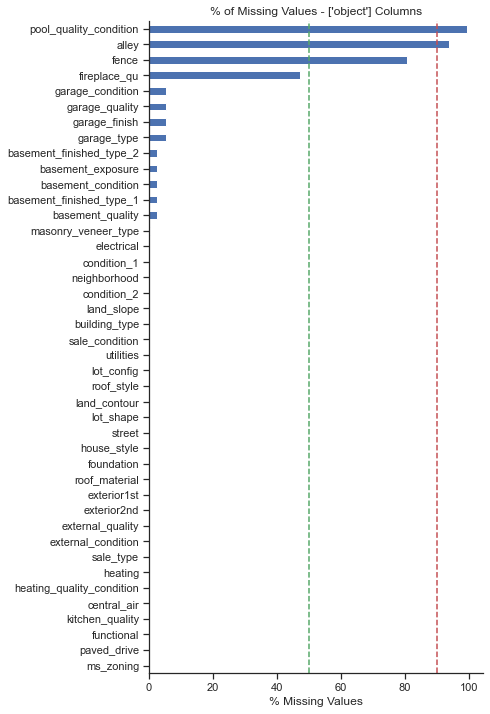

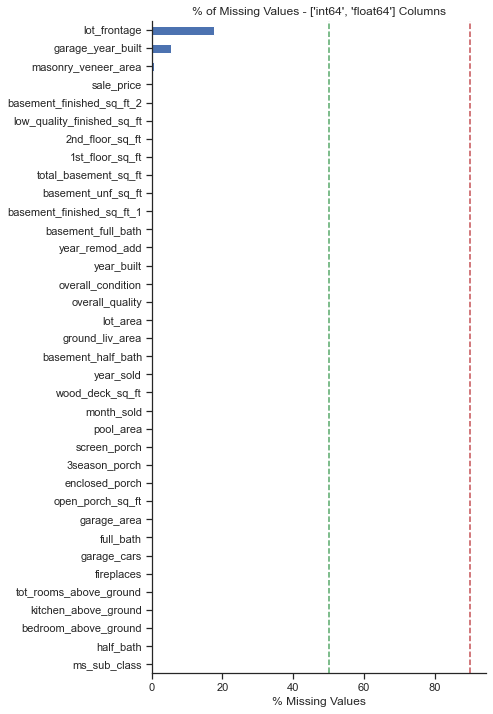

In [12]:
sns.set_theme(
    style="ticks", 
    # palette=sns.color_palette("Set1"), 
    rc=custom_params)

# Plot percentage of missing data
for dtypes in [['object',], ['int64', 'float64']]:

    plot_perc_missing(
        train.df, 
        title=f'% of Missing Values - {dtypes} Columns',
        dtype_include=dtypes,
        )

In [13]:
train.remove_missing_columns(threshold=MISSING_THRESHOLD_DROP)

Found 3 column(s) with missing values above the 0.5 threshold.
Removed columns:
['alley', 'pool_quality_condition', 'fence']
Table metadata updated


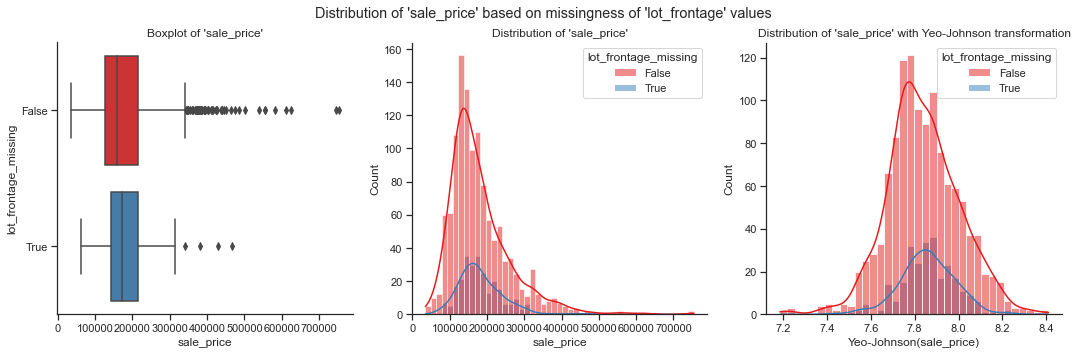

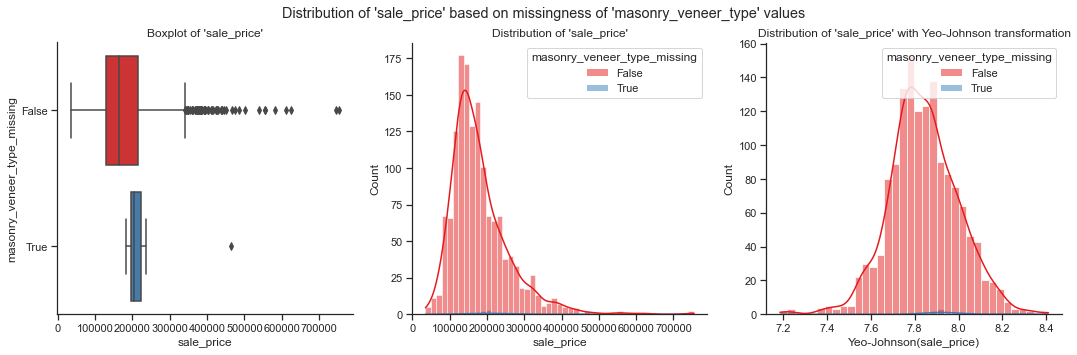

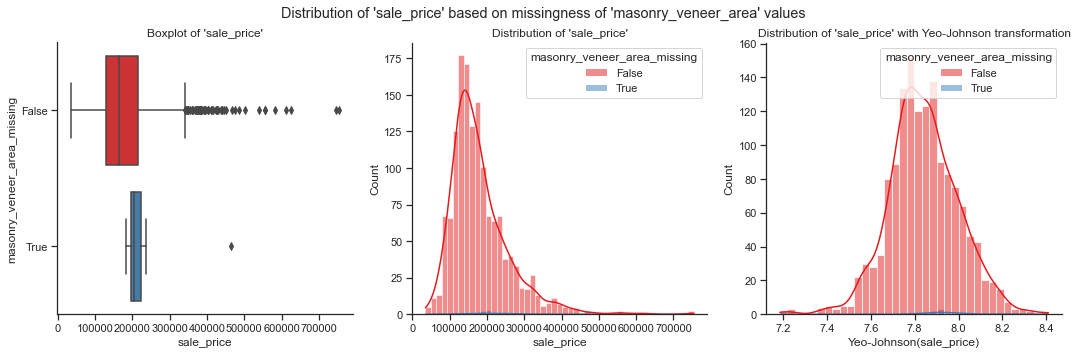

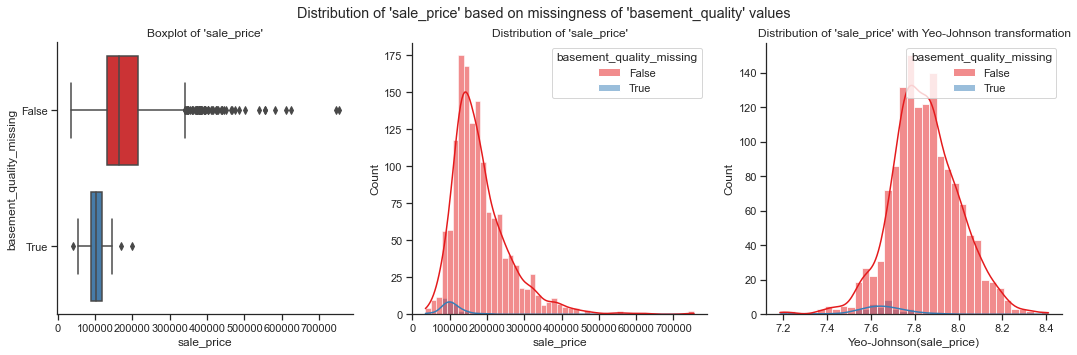

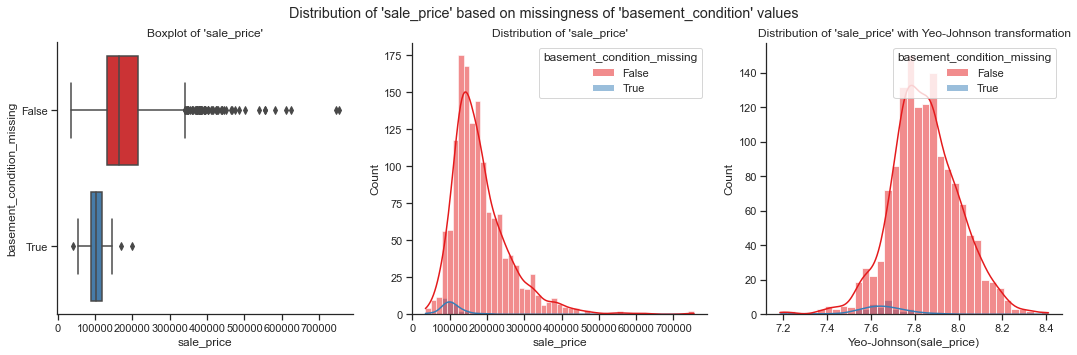

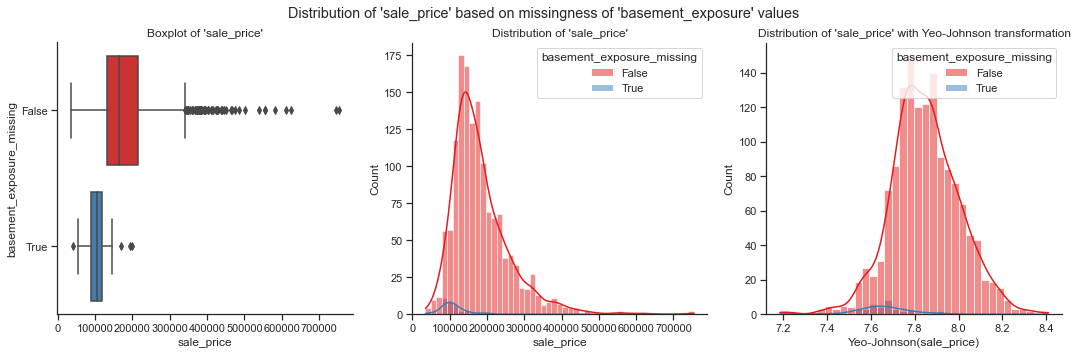

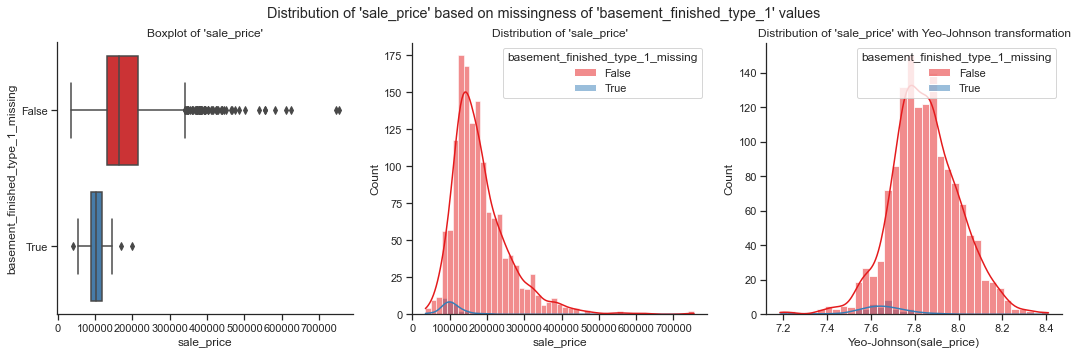

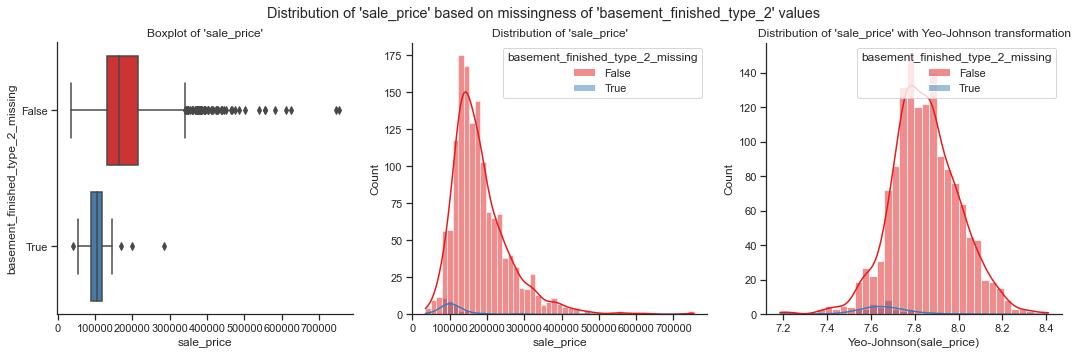

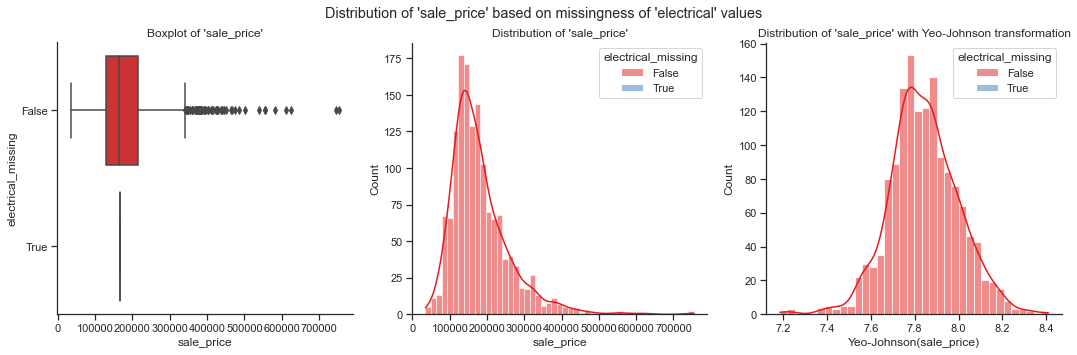

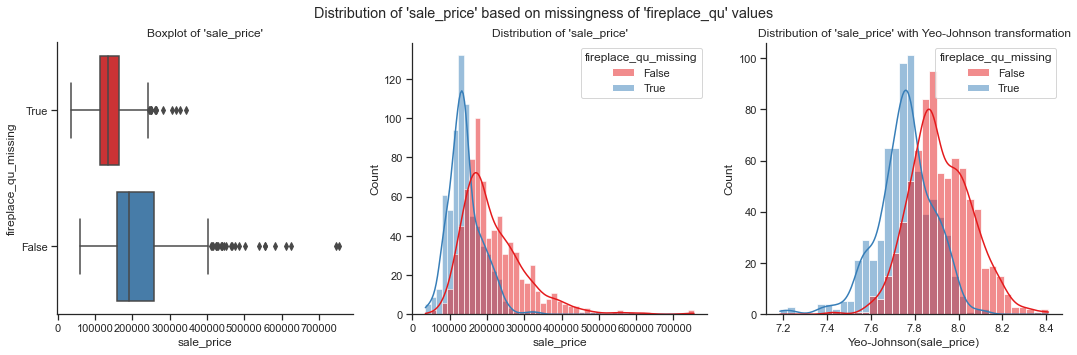

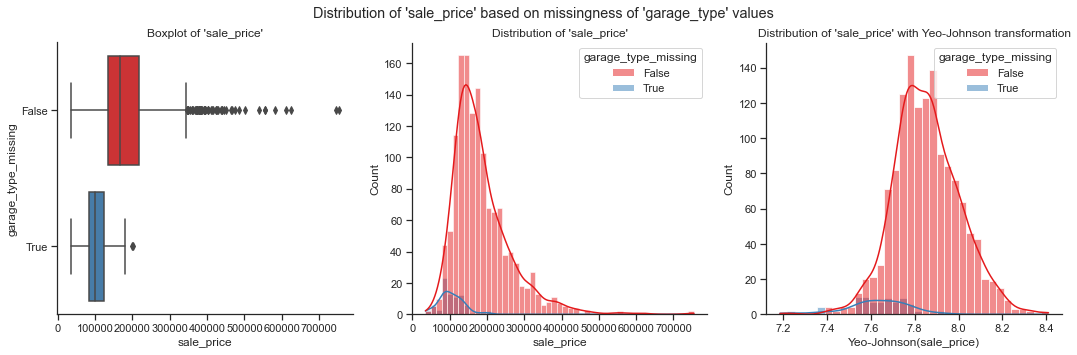

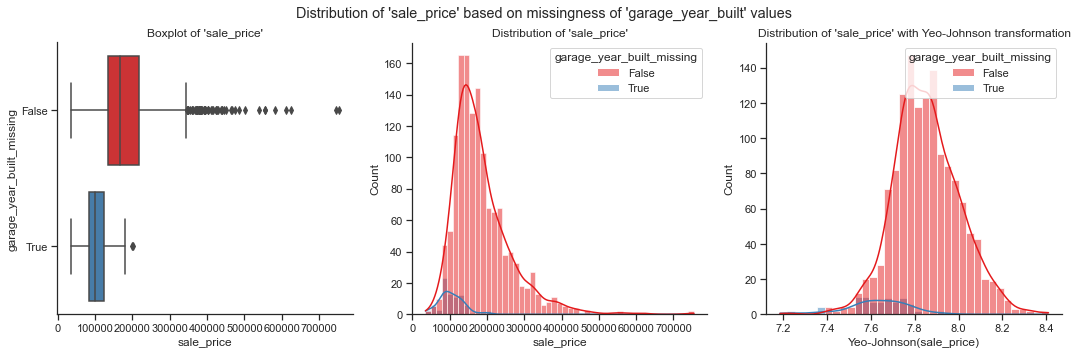

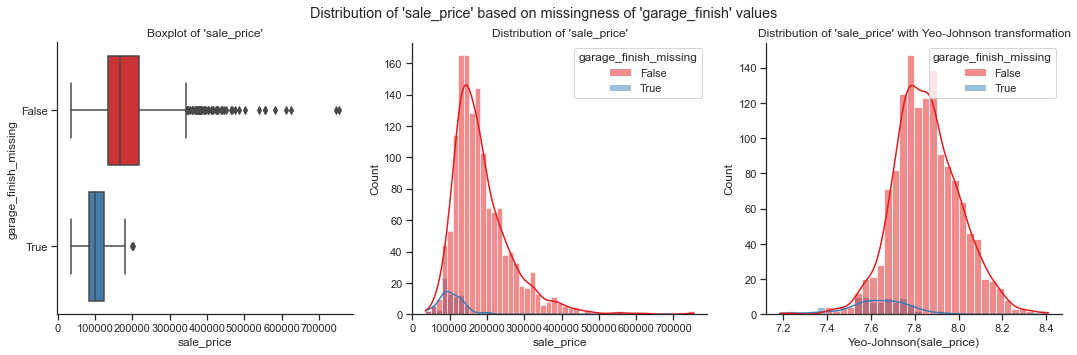

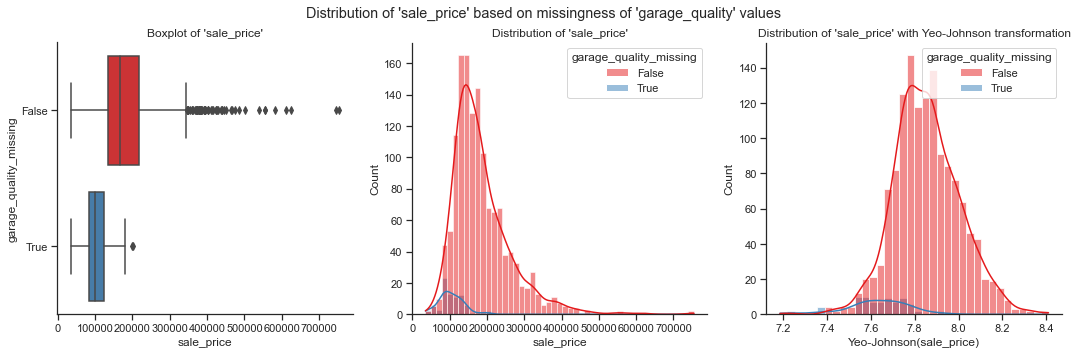

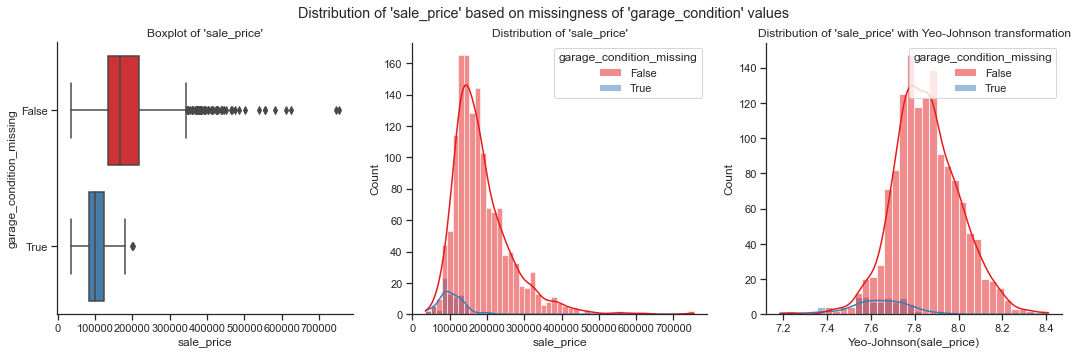

In [14]:
col_missing_bool = train.df.apply(lambda x: x.isnull().sum() > 0)
col_missing_desc = train.df.columns[col_missing_bool].tolist()

for col in col_missing_desc:

    boxplot_histogram_missingness_relationship(
        df=train.df, 
        col_var=col, 
        col_target=train.col_target, 
        add_kde=True,
        add_yeojohnson=True)

In [15]:
train.add_flag_missing_values(
    ttest_threshold=FLAG_MISSING_PVALUE_TRESHOLD,
    ttest_min_samples=FLAG_MISSING_MIN_SAMPLES, 
    yeojohnson_transform=True
    )


lot_frontage
Not adding flag for 'lot_frontage', p-value above the threshold 0.01000: 0.029580343055

masonry_veneer_type
Skipping 'masonry_veneer_type' due to data size being below threshold 8

masonry_veneer_area
Skipping 'masonry_veneer_area' due to data size being below threshold 8

basement_quality
Skipping 'basement_quality' due to data size being below threshold 37

basement_condition
Skipping 'basement_condition' due to data size being below threshold 37

basement_exposure
Skipping 'basement_exposure' due to data size being below threshold 38

basement_finished_type_1
Skipping 'basement_finished_type_1' due to data size being below threshold 37

basement_finished_type_2
Skipping 'basement_finished_type_2' due to data size being below threshold 38

electrical
Skipping 'electrical' due to data size being below threshold 1

fireplace_qu
Adding flag for 'fireplace_qu', p-value below the threshold 0.01000: 0.000000000000
Table metadata updated

garage_type
Adding flag for 'garage_t

## Create features from time data

In [16]:
train.create_column(
    col_name='year_built_or_remod', 
    values=train.df[['year_remod_add', 'year_built']].apply(np.max, axis=1))

def x(a,b):
    return np.max([a-b, 0])

# Calculate age when sold
train.create_column(
    col_name='age_garage_when_sold',
    values=train.df.apply(lambda f: x(f['year_sold'], f['garage_year_built']), axis=1))

train.create_column(
    col_name='age_house_when_sold', 
    values=train.df.apply(lambda f: x(f['year_sold'], f['year_built_or_remod']), axis=1))

train.drop_columns_regex(regex='year(?!.+missing$)')

Table metadata updated
Created column 'year_built_or_remod'
Table metadata updated
Created column 'age_garage_when_sold'
Table metadata updated
Created column 'age_house_when_sold'

Removed columns:
['year_built', 'year_remod_add', 'garage_year_built', 'year_sold', 'year_built_or_remod']
Table metadata updated


## Discrete Features

In [17]:
# ms_sub_class is a categorical feature
train.change_column_types({'ms_sub_class': 'object'})

Changed 'ms_sub_class' to 'object' type


In [18]:
train.print_column_types()

There are 47 categorical fields:
['ms_sub_class', 'ms_zoning', 'street', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'building_type', 'house_style', 'roof_style', 'roof_material', 'exterior1st', 'exterior2nd', 'masonry_veneer_type', 'external_quality', 'external_condition', 'foundation', 'basement_quality', 'basement_condition', 'basement_exposure', 'basement_finished_type_1', 'basement_finished_type_2', 'heating', 'heating_quality_condition', 'central_air', 'electrical', 'kitchen_quality', 'functional', 'fireplace_qu', 'garage_type', 'garage_finish', 'garage_quality', 'garage_condition', 'paved_drive', 'sale_type', 'sale_condition', 'fireplace_qu_missing', 'garage_type_missing', 'garage_year_built_missing', 'garage_finish_missing', 'garage_quality_missing', 'garage_condition_missing', 'age_house_when_sold']
There are 32 numerical fields:
['lot_frontage', 'lot_area', 'overall_quality', 'overall_condition', 'masonry

In [19]:
discrete_cols   = [col for col in train.num_columns if len(train.df[col].unique()) < 20]
continuous_cols = [col for col in train.num_columns if col not in discrete_cols]

train.df[discrete_cols].head(10)

,overall_quality,overall_condition,basement_full_bath,basement_half_bath,full_bath,half_bath,bedroom_above_ground,kitchen_above_ground,tot_rooms_above_ground,fireplaces,garage_cars,pool_area,month_sold
Id,,,,,,,,,,,,,
1,7,5,1,0,2,1,3,1,8,0,2,0,2
2,6,8,0,1,2,0,3,1,6,1,2,0,5
3,7,5,1,0,2,1,3,1,6,1,2,0,9
4,7,5,1,0,1,0,3,1,7,1,3,0,2
5,8,5,1,0,2,1,4,1,9,1,3,0,12
6,5,5,1,0,1,1,1,1,5,0,2,0,10
7,8,5,1,0,2,0,3,1,7,1,2,0,8
8,7,6,1,0,2,1,3,1,7,2,2,0,11
9,7,5,0,0,2,0,2,2,8,2,2,0,4


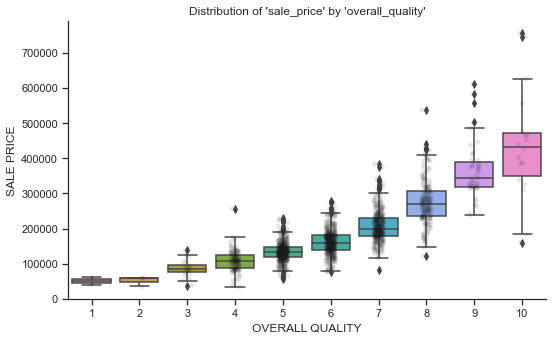

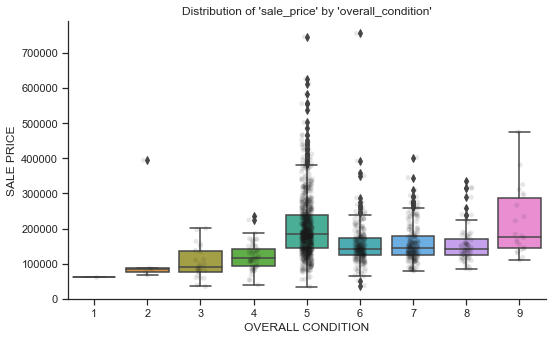

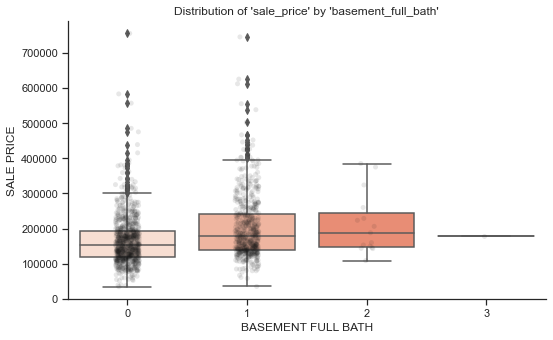

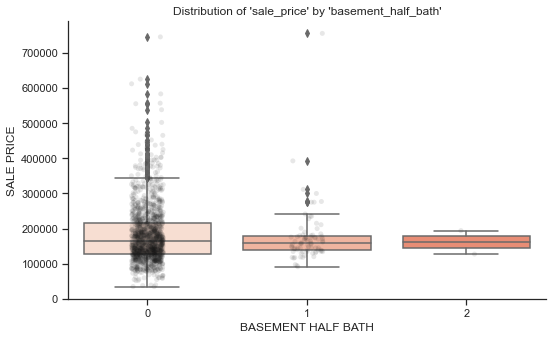

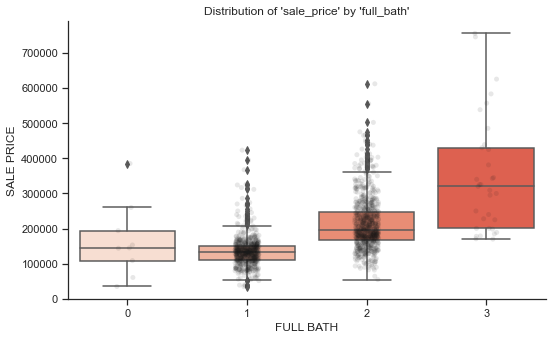

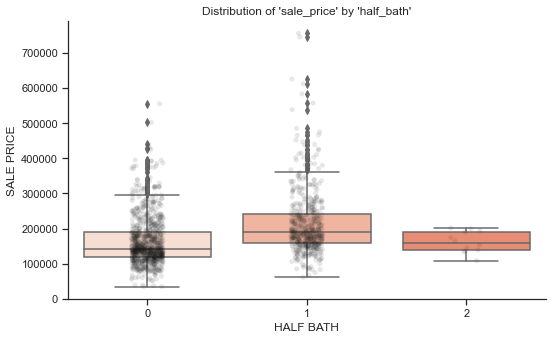

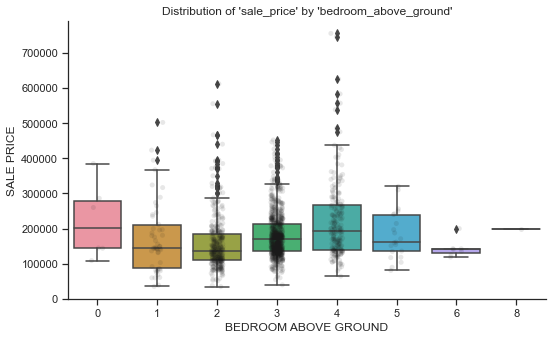

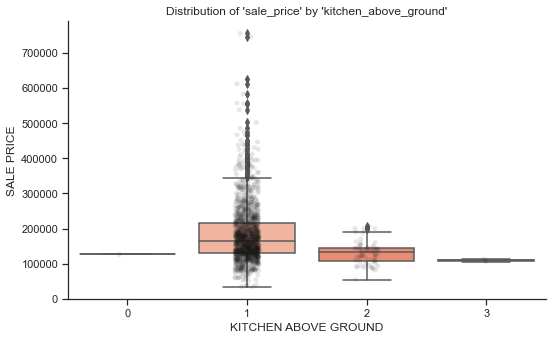

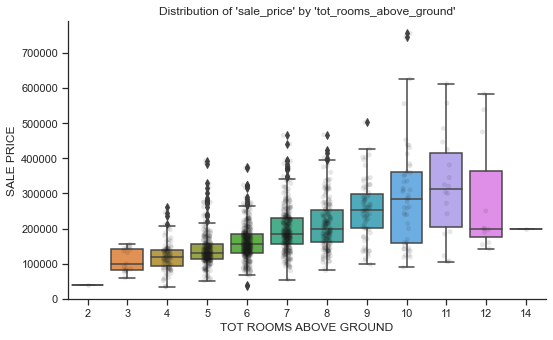

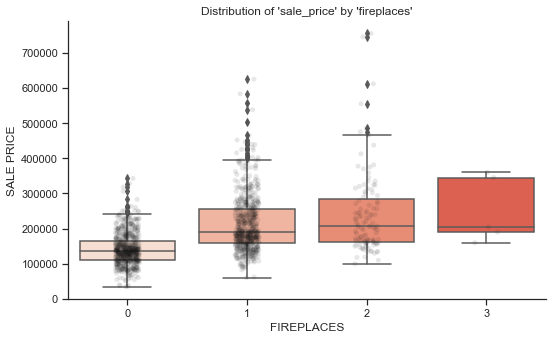

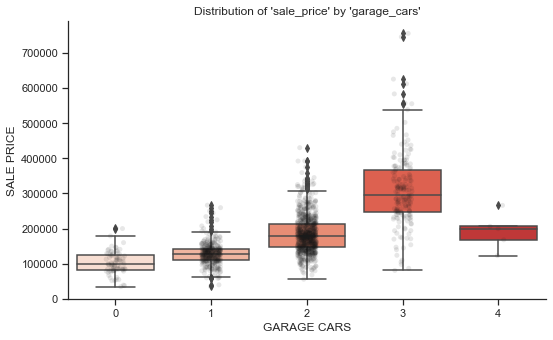

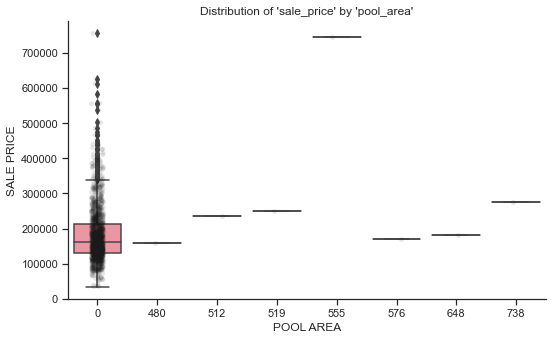

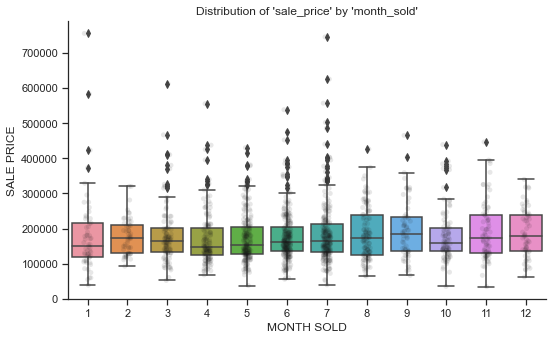

In [20]:
for col in discrete_cols:
    
    sns.set_theme(
            style="ticks", 
            palette=sns.color_palette("Reds"), 
            rc=custom_params)
    
    sns.catplot(data=train.df, x=col, y=COL_TARGET, kind='box', height=4.5, aspect=1.7)
    sns.stripplot(data=train.df, x=col, y=COL_TARGET, jitter=0.1, alpha=0.1, color='k')
    plt.title(f'Distribution of \'{COL_TARGET}\' by \'{col}\'')
    plt.ylabel(COL_TARGET.replace('_', ' ').upper())
    plt.xlabel(col.replace('_', ' ').upper())
    plt.show()

## Numerical features

In [21]:
train.df[continuous_cols].head()

,lot_frontage,lot_area,masonry_veneer_area,basement_finished_sq_ft_1,basement_finished_sq_ft_2,basement_unf_sq_ft,total_basement_sq_ft,1st_floor_sq_ft,2nd_floor_sq_ft,low_quality_finished_sq_ft,ground_liv_area,garage_area,wood_deck_sq_ft,open_porch_sq_ft,enclosed_porch,3season_porch,screen_porch,sale_price,age_garage_when_sold
Id,,,,,,,,,,,,,,,,,,,
1,65.0,8450,196.0,706,0,150,856,856,854,0,1710,548,0,61,0,0,0,208500,5.0
2,80.0,9600,0.0,978,0,284,1262,1262,0,0,1262,460,298,0,0,0,0,181500,31.0
3,68.0,11250,162.0,486,0,434,920,920,866,0,1786,608,0,42,0,0,0,223500,7.0
4,60.0,9550,0.0,216,0,540,756,961,756,0,1717,642,0,35,272,0,0,140000,8.0
5,84.0,14260,350.0,655,0,490,1145,1145,1053,0,2198,836,192,84,0,0,0,250000,8.0


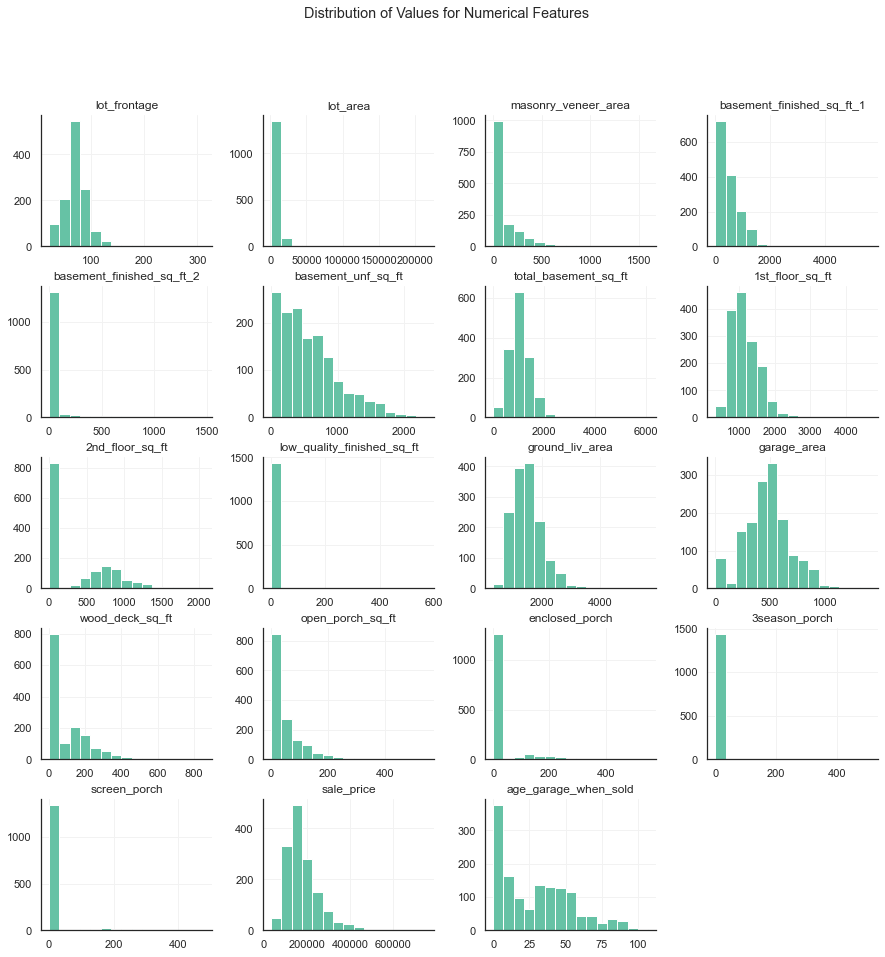

In [53]:
sns.set_theme(
            style="white", 
            palette=sns.color_palette("Set2"), 
            rc={
                "axes.grid": False, 
                "grid.color": '0.95', 
                "axes.spines.right": False, 
                "axes.spines.top": False
                })

train.df.loc[:, continuous_cols].hist(bins=15, figsize=(15,15))
plt.suptitle(f'Distribution of Values for Numerical Features')
plt.show()

## Feature Correlation

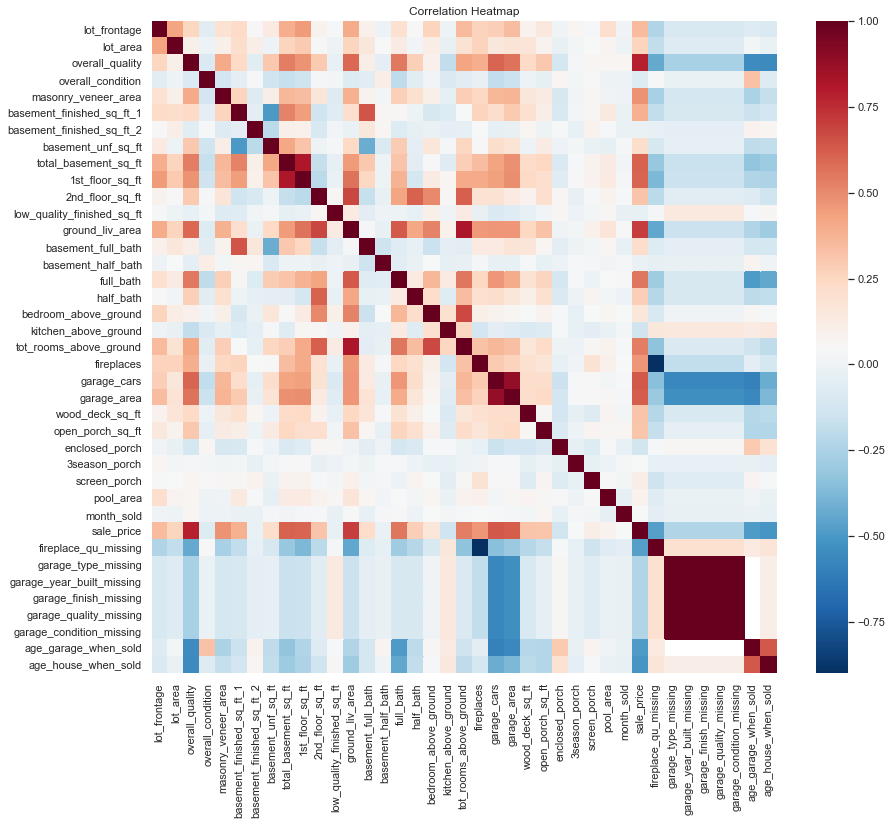

In [65]:
plot_correlation_heatmap(train.df)

### Remove Features with low correlation to target

In [72]:
train.df.corr()[COL_TARGET].abs().sort_values(ascending=False)

sale_price                    1.000000
overall_quality               0.790982
ground_liv_area               0.708624
garage_cars                   0.640409
garage_area                   0.623431
total_basement_sq_ft          0.613581
1st_floor_sq_ft               0.605852
full_bath                     0.560664
tot_rooms_above_ground        0.533723
age_house_when_sold           0.509096
age_garage_when_sold          0.487069
masonry_veneer_area           0.477493
fireplace_qu_missing          0.471908
fireplaces                    0.466929
basement_finished_sq_ft_1     0.386420
lot_frontage                  0.351799
wood_deck_sq_ft               0.324413
2nd_floor_sq_ft               0.319334
open_porch_sq_ft              0.315856
half_bath                     0.284108
lot_area                      0.263843
garage_condition_missing      0.236832
garage_quality_missing        0.236832
garage_finish_missing         0.236832
garage_year_built_missing     0.236832
garage_type_missing      